### This is a code sample where I analyse the data in the LEGO Parts/Sets/Colors and Inventories of every official LEGO set in the Rebrickable database

Database Schema and Data Download URL: https://rebrickable.com/downloads/
<br>
<br> Note: I have no ownership over this dataset and affiliations to this website.

<br> This analysis (code + insighting) is done in 2 hours.
<br> To view my up-to-date CV, please visit http://bit.ly/cv_giaphattram
<br> To view my qualifications, please visit http://bit.ly/giaphattram
<br> To see project and code samples, please visit http://www.github.com/giaphattram


### This notebook is structured in three parts.
<br>
<li> Part 1: Introduction to the Data Schema and the Visualizations
<br> Familiarize readers with this dataset
<br> Introduce the visualizations and the potential analytical questions that the visualizations can help introduce.
<br>
<br>
<li> Part 2: Data Processing
<br> Process the data to generate pivot tables for data visualization in part 2. 
<br> Demonstrate Python Pandas skill
<br> Please feel free to skip ahead to Part 3
<br>
<br>
<li> Part 3: Visualizations and Analysis
<br>
<br>
<li> Appendix: 
<br> Display all pivot tables visualized in Part 3
<br> SQL Query sample to achieve one of the pivot tables and some comments on BigQuery and Python.

## -------------------------------------------------------------

Import packages used in the analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from IPython.display import Image 
#path = directory where you keep the .csv files
#os.chdir(path)

# Part 1: Schema Explanation and Charts Introduction

### Schema Description

To enable viewers to quickly familiarize with this dataset, I'd like to briefly explain the schema (see image below). 
<br> 
<br> Essentially, this database contains inventory data for Lego products, and this inventory data is at two levels, namely set level ("inventory_sets" table) and part level ("inventory_parts" table)
<br> 
<br> Data for each Lego set is in "sets" table, which has information such as set name, year, the number of parts, and the theme of the set given as a foreign key linking to "themes" table. 
<br>
<br> Data for each part is in "parts" table, which has information such as part name, part category which is given as foreign key linking to "part_categories" table. Each part may have different colors, that's why "inventory_parts" table has foreign key linking to colors table.
<br>
<br> Data at set level and part level can be linked together via "inventories" table
<br>

In [2]:
Image(url= "https://rebrickable.com/static/img/diagrams/downloads_schema.png")

Disclaimer: Image (and data) is not mine.

### Charts Introduction

The visualizations and Analysis part are motivated by the schema. The first chart involve data set part level, the second chart involves data at set level, the third chart involves data that connects both levels.
<br>
<br>
The first chart is the heat map of the pivot table where one dimension is the part category, one dimension is the colors, and the aggregated values are the counts of inventory parts that have the respective color and belong to the respective category. This chart allows for analytical questions such as: what is the relationship between colors and part categories in the inventory? What are the most popular and least popular colors? Are there parts that have inventory in various colors and parts that have inventory in few simple colors? 
<br>
<br>
The second chart is the heat map of the pivot table where one dimension is the year, one dimension is the theme, and the aggregated values are the counts of sets that are available in the respective year and have the the respective theme. This chart allows for analytical questions such as: which themes exist in which year? which themes persist through the years? In which years there are the most and the least diverse themes in the inventory?
<br>
<br>
The third chart connects the data at set level and part level. It is the heat map of the pivot table where one dimension is the theme, one dimension is the part color, and the aggregated values are the counts of inventory parts that belong to the respective theme and have the respective color. Due to the large size of the pivot table, a number of themes have been selected for the analysis. A number of hypotheses are formulated, such as whether the theme "Fire" has the most parts in red color (answer: yes).
<br>
<br>
The fourth chart is a simple line chart in which the x-axis is the year, the y-axis is the count of set inventories. It can be observed from this chart that the inventories get bigger over the decades, suggesting the growth of Lego company. However, the increase in inventories in the years post-2008 and the subsequent reductions in inventories may suggest a different story, that due to the crisis sales were plummeting and thus the inventories were increasing, and after a few years the inventories became smaller, suggesting recovering sales.

# Part 2: Data Processing

### Processing data for part_categories, parts, colors, inventory_parts

In [3]:
part_categories = pd.read_csv("part_categories.csv") #basically just the categories and their ids
part_categories.rename({'name': 'part_cat_name', 'id' : 'part_cat_id'}, axis = 1, inplace = True)
print('The first few records in the part_categories table')
part_categories.head()

The first few records in the part_categories table


,part_cat_id,part_cat_name
0,1,Baseplates
1,2,Bricks Printed
2,3,Bricks Sloped
3,4,"Duplo, Quatro and Primo"
4,5,Bricks Special


In [4]:
parts = pd.read_csv("parts.csv") #Basically actually parts mapped to part_cat_id. Just merge them
parts.rename({'name': 'part_name'}, axis = 1, inplace = True)
parts = pd.merge(left = parts, right = part_categories, left_on = 'part_cat_id', right_on = 'part_cat_id', how = 'left', indicator= True)
print('All parts are merged with the right category: ',parts._merge.nunique()==1)
parts.drop(['part_cat_id', '_merge'], axis = 1, inplace = True)
print("The first few records of the merged parts and part_categories tables")
parts.head()

All parts are merged with the right category:  True
The first few records of the merged parts and part_categories tables


,part_num,part_name,part_cat_name
0,0687b1,Set 0687 Activity Booklet 1,Non-LEGO
1,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,Baseplates
2,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,Baseplates
3,0903,Baseplate 16 x 24 with Set 080 Red House Print,Baseplates
4,0904,Baseplate 16 x 24 with Set 080 Large White Hou...,Baseplates


In [5]:
colors = pd.read_csv("colors.csv") #basically id-color-rgb mapping
print('The first few records of the colors table')
colors.head(2)

The first few records of the colors table


,id,name,rgb,is_trans
0,-1,[Unknown],0033B2,f
1,0,Black,05131D,f


In [6]:
inventory_parts = pd.read_csv('inventory_parts.csv')
#merge with color
inventory_parts = pd.merge(left = inventory_parts, right = colors, left_on = 'color_id', right_on = 'id', how = 'left')
inventory_parts.head()
inventory_parts.drop(['id', 'rgb','is_trans'], axis = 1, inplace = True)
inventory_parts.rename({'name':'color'}, axis = 1, inplace = True)

#merge with parts
inventory_parts = pd.merge(left = inventory_parts, right = parts, on = 'part_num', how = 'left', indicator = True)
print('Merge successful:', inventory_parts._merge.nunique()==1)
inventory_parts.drop('_merge', axis =1 , inplace = True)
inventory_parts.head()

#There are too many colors. Group similar shades of color together, e.g.: dark blue = light blue = blue
inventory_parts['simplified_color'] = inventory_parts.color.str.split('-').str.join('').str.split(' ').str[-1]

#Generate a pivot of simplified_color and 'part_cat_name'
color_part_pivot = pd.pivot_table(inventory_parts, values = 'quantity', index = 'simplified_color', columns = 'part_cat_name', aggfunc='sum')

Merge successful: True


### Processing data for themes, sets, inventory_sets

In [7]:
themes = pd.read_csv("themes.csv")
themes.rename({'id': 'theme_id', 'name': 'theme_name'}, axis = 1, inplace = True)
print('The first few records of the themes table')
themes.head()

The first few records of the themes table


,theme_id,theme_name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0


In [8]:
sets = pd.read_csv("sets.csv") #each set is connected to a theme, let's merge them
sets.rename({'name': 'set_name'}, axis = 1,inplace = True)
sets = pd.merge(left = sets, right = themes, on = 'theme_id', how = 'left', indicator=True)
print('All rows in sets are merged with a theme: ',sets._merge.nunique()==1)
sets.drop('_merge', axis =1 , inplace = True)
print('The first few records of the merged sets and themes tables')
sets.head()

All rows in sets are merged with a theme:  True
The first few records of the merged sets and themes tables


,set_num,set_name,year,theme_id,num_parts,theme_name,parent_id
0,00-1,Weetabix Castle,1970,414,471,Castle,411.0
1,001-1,Gears,1965,1,43,Technic,NaN
2,0011-2,Town Mini-Figures,1978,84,12,Supplemental,67.0
3,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,Lion Knights,186.0
4,0012-1,Space Mini-Figures,1979,143,12,Supplemental,126.0


In [9]:
inventory_sets = pd.read_csv("inventory_sets.csv")
#merge to sets
inventory_sets = pd.merge(left = inventory_sets, right = sets, on = 'set_num', how = 'left', indicator = True)
print('Merging successful: ',inventory_sets._merge.nunique() == 1)
inventory_sets.drop(['_merge'], axis = 1, inplace = True)
print('The first few records of the inventory_sets and sets tables')
inventory_sets.head()

Merging successful:  True
The first few records of the inventory_sets and sets tables


,inventory_id,set_num,quantity,set_name,year,theme_id,num_parts,theme_name,parent_id
0,35,75911-1,1,McLaren Mercedes Pit Stop,2015,601,340,Speed Champions,NaN
1,35,75912-1,1,Porsche 911 GT Finish Line,2015,601,570,Speed Champions,NaN
2,39,75048-1,1,The Phantom,2014,182,234,Star Wars Rebels,158.0
3,39,75053-1,1,The Ghost,2014,182,928,Star Wars Rebels,158.0
4,50,4515-1,1,Straight Rails,1991,244,8,9V,241.0


In [10]:
#Generate year_theme_pivot
year_theme_pivot = pd.pivot_table(data = inventory_sets, index = 'theme_name', columns = 'year', values = 'quantity', aggfunc = 'sum')

### Processing data for mapping themes, sets, inventories, inventory_parts, colors, parts, part_categories

In [11]:
inventories = pd.read_csv("inventories.csv")
#print(inventories.shape)
#print(inventories.columns)
print('The first few records of inventories table')
inventories.head(2)

The first few records of inventories table


,id,version,set_num
0,1,1,7922-1
1,3,1,3931-1


In [12]:
print("Merging all the tables together")
inventories_sets_merge = pd.merge(left = inventories, right = sets, on ='set_num', how = 'left', indicator = True)
print('Merging successful: ', inventories_sets_merge._merge.nunique()==1)
inventories_sets_merge.drop(['_merge','parent_id', 'num_parts'], axis = 1, inplace = True)
superMerge = pd.merge(left = inventory_parts, right = inventories_sets_merge, how = 'left', left_on = 'inventory_id', right_on = 'id', indicator = True)
print('Merging successful: ', superMerge._merge.nunique()==1)
superMerge.drop(['_merge', 'version','id'], axis = 1, inplace = True)
print('The first few records of the merge of all tables')
superMerge.head()

Merging all the tables together
Merging successful:  True
Merging successful:  True
The first few records of the merge of all tables


,inventory_id,part_num,color_id,quantity,is_spare,color,part_name,part_cat_name,simplified_color,set_num,set_name,year,theme_id,theme_name
0,1,48379c01,72,1,f,Dark Bluish Gray,Sports Promo Figure Base with Feet,Minifig Accessories,Gray,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,Gravity Games
1,1,48395,7,1,f,Light Gray,Sports Snowboard from McDonald's Promotional Set,Minifig Accessories,Gray,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,Gravity Games
2,1,mcsport6,25,1,f,Orange,Sports Promo Figure Head Torso Assembly McDona...,Minifigs,Orange,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,Gravity Games
3,1,paddle,0,1,f,Black,Sports Promo Paddle from McDonald's Sports Sets,Minifig Accessories,Black,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,Gravity Games
4,3,11816pr0005,78,1,f,Light Flesh,"Minidoll Head with Green Eyes, Pink Lips and C...",Minidoll Heads,Flesh,3931-1,Emma's Splash Pool,2012,494,Friends


In [13]:
#Generate color_theme_pivot
color_theme_pivot = pd.pivot_table(data = superMerge, values= 'quantity', index = 'theme_name', columns = 'simplified_color', aggfunc = 'sum')

# Part 3: Data Visualization and Insighting

(copy/paste from the Chart Introduction in Part 1)
<br>
<br>
The visualizations and Analysis part are motivated by the schema. The first chart involve data set part level, the second chart involves data at set level, the third chart involves data that connects both levels.
<br>
<br>
The first chart is the heat map of the pivot table where one dimension is the part category, one dimension is the colors, and the aggregated values are the counts of inventory parts that have the respective color and belong to the respective category. This chart allows for analytical questions such as: what is the relationship between colors and part categories in the inventory? What are the most popular and least popular colors? Are there parts that have inventory in various colors and parts that have inventory in few simple colors? 
<br>
<br>
The second chart is the heat map of the pivot table where one dimension is the year, one dimension is the theme, and the aggregated values are the counts of sets that are available in the respective year and have the the respective theme. This chart allows for analytical questions such as: which themes exist in which year? which themes persist through the years? In which years there are the most and the least diverse themes in the inventory?
<br>
<br>
The third chart connects the data at set level and part level. It is the heat map of the pivot table where one dimension is the theme, one dimension is the part color, and the aggregated values are the counts of inventory parts that belong to the respective theme and have the respective color. Due to the large size of the pivot table, a number of themes have been selected for the analysis. A number of hypotheses are formulated, such as whether the theme "Fire" has the most parts in red color (answer: yes).
<br>
<br>
The fourth chart is a simple line chart in which the x-axis is the year, the y-axis is the count of set inventories. It can be observed from this chart that the inventories get bigger over the decades, suggesting the growth of Lego company. However, the increase in inventories in the years post-2008 and the subsequent reductions in inventories may suggest a different story, that due to the crisis sales were plummeting and thus the inventories were increasing, and after a few years the inventories became smaller, suggesting recovering sales.

# First Chart: Quantities of (color, part categories) pairs 
##### 4 tables used: part_categories, parts, inventory_parts, colors

Text(0.5, 1.0, 'Heatmap of Quantities sorted by Simplied Color and Part Categories')

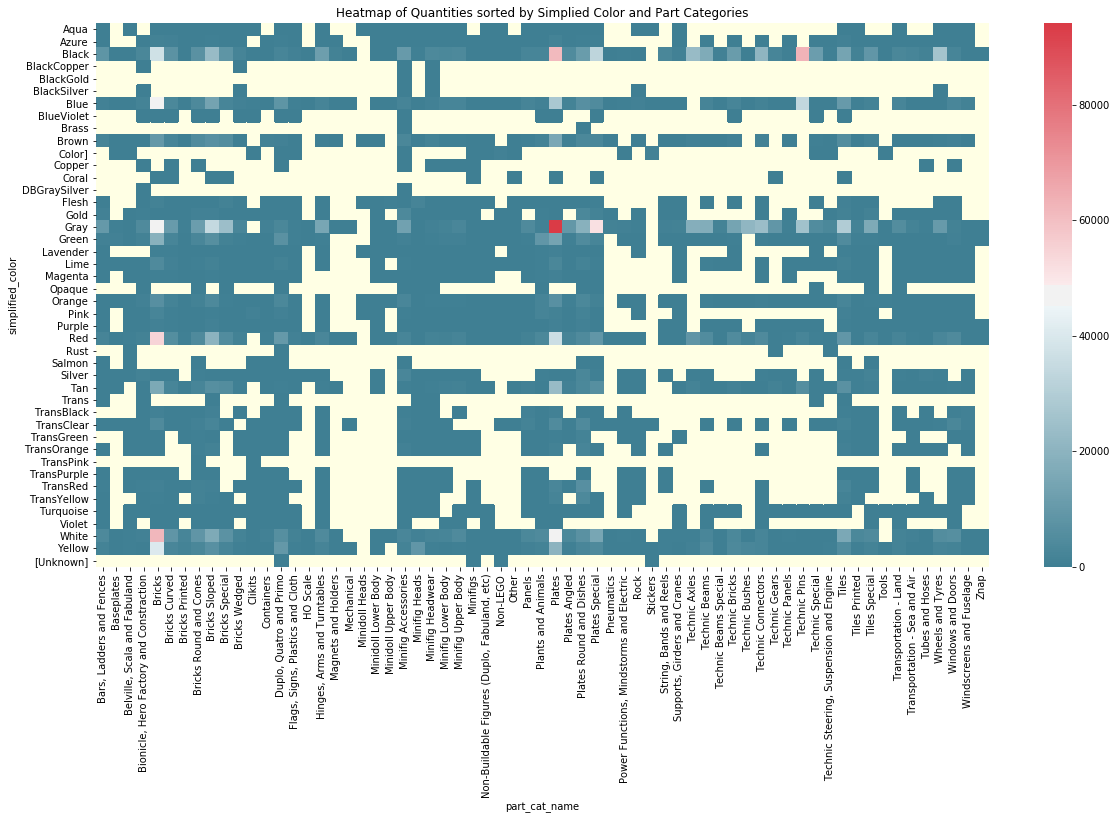

In [14]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (20,10))
chart1 = sns.heatmap(color_part_pivot, cmap = cmap, xticklabels=True, yticklabels=True)
chart1.set_facecolor('xkcd:off white')
plt.title('Heatmap of Quantities sorted by Simplied Color and Part Categories')

### Chart 1 Description
This graph is a heatmap of the inventory quantity by any given simplified color and part category pair. The x-axis contains the part categories and the y-axis the simplified colors. Simplified color is a group of different shades of similar colors * . For example, light pink and dark pink are grouped into the same simplified color pink. 
<br>
<br> Please note that the names are sorted by Alphabet order.
<br>
<br> On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (light yellowish color) as quantity of 0.
<br>
<br>This heatmap allows for immediately seeing a big picture of the inventory quantity of each pair and identifying the pairs that have no inventory (indicated by light yellowish color), the pairs that have very low quantity (indicated by dark blue), the pairs that have the most inventory (indicated by shades of red), the pairs that have moderately high quantity in inventory (indicated by light colors and white). Looking at the graph, 6 pixels in shades of red / light red immediately stands out. 
<br>
<br> The pairs that have the biggest quantity is Gray-Plates,  followed by White-Bricks, Plates-Black, Black-TechnicPins.
<br>
<br> We can also analyze the graph by color or by part category. For example, BlackGold is among the least popular colors as only two part categories (minifig accessories and minifig headwear) have this color. Minifig accessories, on the other hand, is among the part categories that have the biggest variety of colors.
<br>
<br> * Some simplified colors are still actually quite similar, for example BlackSilver and Silver. I don't have enough time to group colors such as these two together.

# Chart 2: Quantities of sets by (year, theme) pairs

##### 3 tables used: inventory_sets, sets, themes

Text(0.5, 1.0, 'Inventory quantity by year-theme')

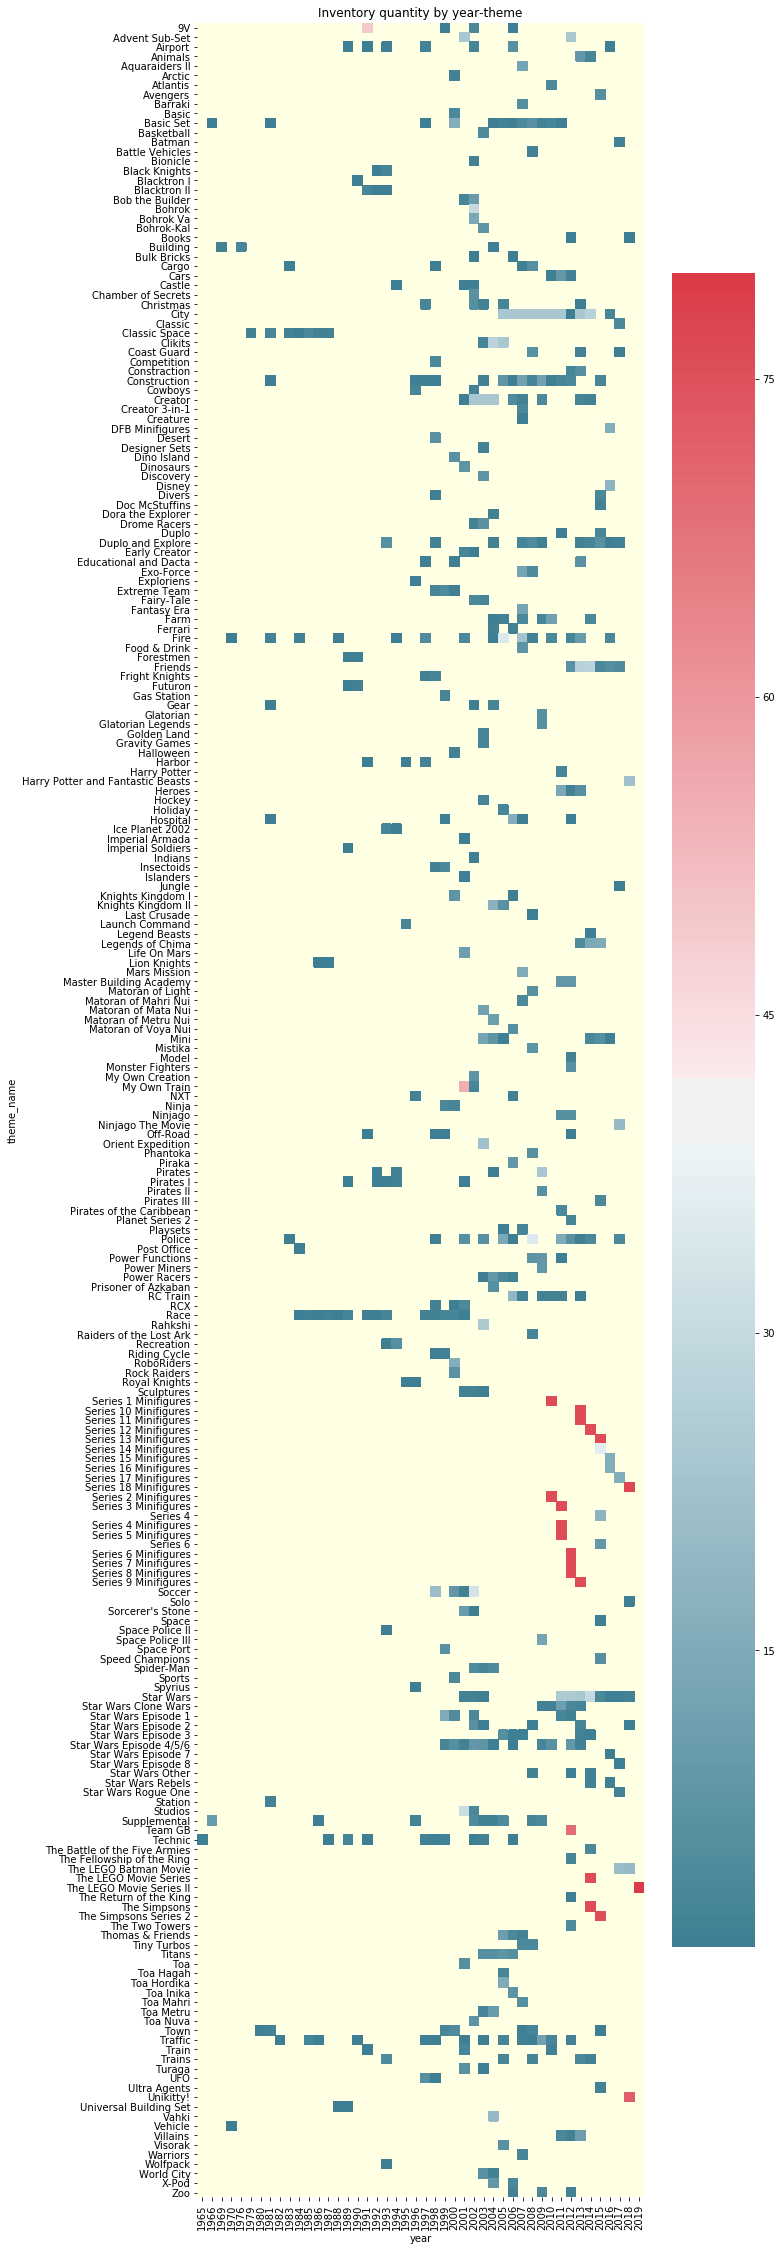

In [15]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (10,40))
chart2 = sns.heatmap(year_theme_pivot, cmap = cmap, xticklabels=True, yticklabels=True)
chart2.set_facecolor('xkcd:off white')
plt.title('Inventory quantity by year-theme')

### Chart 2 Description

This graph is a heatmap of the inventory quantity by any given (year, theme) pair. The x-axis contains the years and the y-axis the themes. On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (ligh yellowish color) as quantity of 0.

This graph allows for immediately seeing which sets are available in which year. For example, 'Vehicle' theme only exists in the inventory in 1970.

We can also immediately see which themes exist in the inventory over many years. For example, 'Forestmen' theme existed in the inventory over the course of 5 years from 2012 to 2017. This could indicate that this theme was a popular trend during those 5 years and is over after 2017. Some themes exist in the inventory across decades. For example, 'Traffic' theme sporadically existed in the inventory between 1982 and 2012.

Another interesting insight is the particularly popular sets colored in red. 'Series [number] minifigures' is a particular successful set of themes, as they have the highest inventories among all themes and across all years. Of course this relies on the assumption that the higher inventory means there is more demand and so Lego produces more and increases the stocks ready for sales. 

# Chart 3: Quantities of sets by (color, theme) pairs

##### All tables are used except inventory_sets

Text(0.5, 1.0, 'Inventory Quantity by Theme-Color')

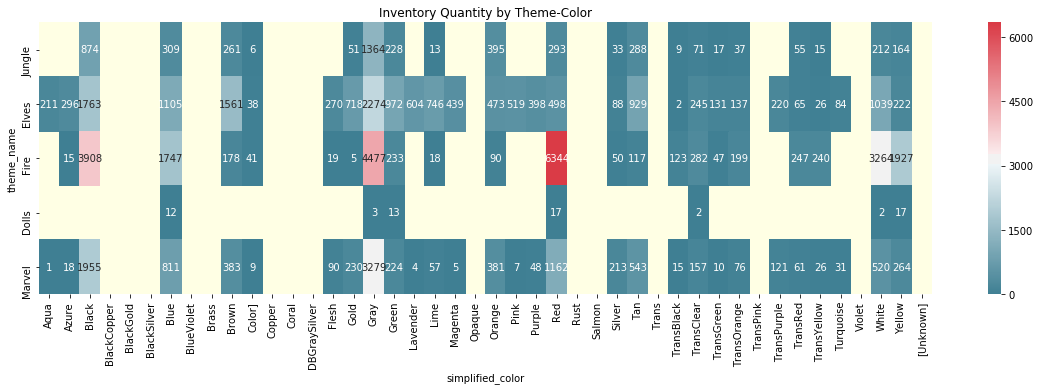

In [16]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (20,5))
chart2 = sns.heatmap(color_theme_pivot.loc[['Jungle', 'Elves', 'Fire', 'Dolls', 'Marvel']], annot = True, fmt = 'g', cmap = cmap, xticklabels=True, yticklabels=True)
chart2.set_facecolor('xkcd:off white')
plt.title('Inventory Quantity by Theme-Color')

### Chart 3 Description

This graph is a heatmap of the inventory quantity by any given (simplified color, theme) pair. The x-axis contains the themes and the y-axis the simplified colors. On the right hand side there is a vertical bar where the color range corresponds with the quantity. The very light yellowish color indicates pairs that do not have data in the dataset. Please note that the darkest shades of blue indicate very low quantity, but not 0. We can treat missing values (ligh yellowish color) as quantity of 0.

The reason I created this chart is because I want to see if some themes have particular color schemes that are more leaning towards particular simplified colors. I select the following themes: 'Jungle', 'Elves', 'Fire', 'Dolls', 'Marvel'.
<br>
<br>My hypothesis:
<br>
<br>'Jungle' has more green
<br>'Elves' has more white and gray
<br>'Fire' has more red
<br>'Dolls' has more pink
<br>'Marvel' has more black and grey

Graph observation: 
<br>
<br>Surprising, 'Jungle' does not have as many green as they have black.

Most consistent with my hypothesis is the 'Fire' theme, where the total number of parts that have red color is the highest.

'Elves' have high number of parts that have the colors black, blue, brown, gray, white; which is reasonable.

'Dolls' surprisingly is the least colorful, having parts with only blue, gray, green, red, transclear, white and yellow.

'Marvel' is more colorful than I expected. Gray is the dominant color in the theme "Marvel", followed by black, consistent with my hypothesis.

<br> Disclaimer: This is not actually hypothesis testing. This is simple exploratory data analysis. For rigorous demonstration of hypothesis testing using statistical tests, please read my finance research project papers available at www.bit.ly/giaphattram.


# Chart 4: Total set quantity in inventory by year

Text(0, 0.5, 'Quantity')

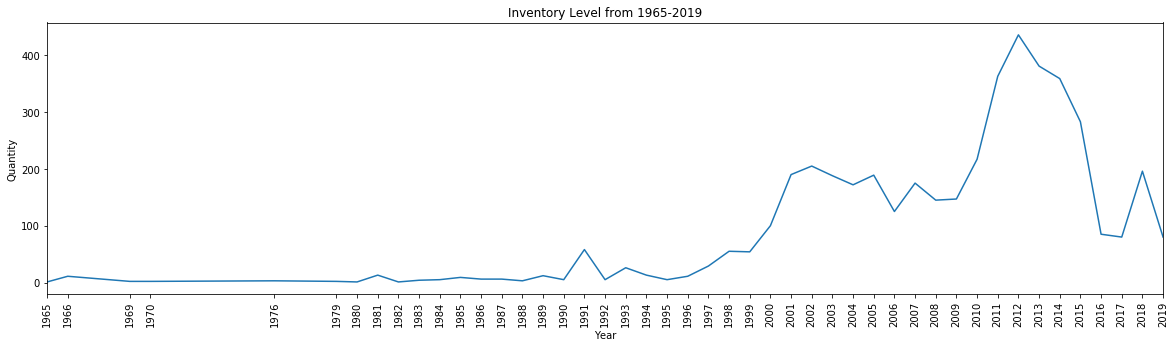

In [17]:
setByYear = inventory_sets.groupby('year')['quantity'].sum()
plt.figure(figsize=(20,5))
setByYear.plot(xticks = setByYear.index, rot = 90)
plt.title('Inventory Level from 1965-2019')
plt.xlabel('Year')
plt.ylabel('Quantity')

### Chart 4 Description

This chart shows the total number of sets in the inventory by year. Naturally, we would expect more recent years to have larger inventories as the company LEGO gets bigger. 

However, it could be observed that the inventories were increasing significantly following the financial crisis in 2008. The stock buildup stops in 2012 and started to go down afterwards. This could mean that after the financial crisis, Lego sales were going down, so stock was built up. After 2012, the economy was recovering and sales started to increasing, thereby reducing stock buildup.

Another reason I create this chart is that since I used heatmap for all the charts above, I may create an impression that I can only create heat map. I just found the heatmaps useful for the questions I have in mind. This chart is to show that I can create any chart.

## ------------------------------------Appendix------------------------------------------------------------

### Pivot Table for Chart 1: color_part_pivot

In [18]:
color_part_pivot

part_cat_name,"Bars, Ladders and Fences",Baseplates,"Belville, Scala and Fabuland","Bionicle, Hero Factory and Constraction",Bricks,Bricks Curved,Bricks Printed,Bricks Round and Cones,Bricks Sloped,Bricks Special,...,Tiles Printed,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage,Znap
simplified_color,,,,,,,,,,,,,,,,,,,,,
Aqua,16.0,NaN,53.0,NaN,208.0,135.0,6.0,12.0,184.0,21.0,...,19.0,NaN,NaN,19.0,NaN,NaN,1.0,8.0,2.0,NaN
Azure,33.0,NaN,NaN,40.0,1305.0,764.0,9.0,353.0,695.0,119.0,...,56.0,112.0,7.0,89.0,8.0,3.0,8.0,36.0,3.0,NaN
Black,8423.0,9.0,109.0,3289.0,37296.0,7555.0,251.0,7064.0,22914.0,8235.0,...,1154.0,8974.0,40.0,3241.0,2319.0,1391.0,26280.0,2441.0,107.0,349.0
BlackCopper,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BlackGold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BlackSilver,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
Blue,968.0,90.0,195.0,1550.0,46169.0,3509.0,329.0,3680.0,13925.0,2316.0,...,385.0,1733.0,NaN,2340.0,342.0,246.0,201.0,2847.0,1266.0,NaN
BlueViolet,NaN,NaN,NaN,11.0,19.0,14.0,NaN,28.0,71.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pivot Table for Chart 2: year_theme_pivot

In [19]:
year_theme_pivot

year,1965,1966,1969,1970,1976,1979,1980,1981,1982,1983,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
theme_name,,,,,,,,,,,,,,,,,,,,,
9V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Advent Sub-Set,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Animals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,3.0,NaN,NaN,NaN,NaN,NaN
Aquaraiders II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlantis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avengers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
Barraki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pivot Table for Chart 3: color_theme_pivot

In [20]:
color_theme_pivot

simplified_color,Aqua,Azure,Black,BlackCopper,BlackGold,BlackSilver,Blue,BlueViolet,Brass,Brown,...,TransOrange,TransPink,TransPurple,TransRed,TransYellow,Turquoise,Violet,White,Yellow,[Unknown]
theme_name,,,,,,,,,,,,,,,,,,,,,
12V,NaN,NaN,2521.0,NaN,NaN,NaN,503.0,NaN,NaN,8.0,...,NaN,NaN,NaN,40.0,22.0,NaN,NaN,376.0,478.0,NaN
4.5V,NaN,NaN,3249.0,NaN,NaN,NaN,1783.0,NaN,NaN,9.0,...,NaN,NaN,NaN,15.0,14.0,NaN,NaN,882.0,1035.0,NaN
9V,NaN,NaN,4128.0,NaN,NaN,NaN,913.0,NaN,NaN,106.0,...,NaN,NaN,NaN,102.0,135.0,NaN,NaN,1420.0,1654.0,NaN
Action Wheelers,NaN,NaN,72.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,26.0,NaN
Advent,NaN,NaN,104.0,NaN,NaN,NaN,64.0,NaN,NaN,20.0,...,3.0,NaN,NaN,8.0,6.0,NaN,NaN,105.0,96.0,NaN
Advent Sub-Set,NaN,NaN,116.0,NaN,NaN,NaN,57.0,NaN,NaN,14.0,...,4.0,NaN,NaN,8.0,4.0,4.0,NaN,113.0,121.0,NaN
Adventurers,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,2.0,NaN
Agents,NaN,NaN,1397.0,NaN,NaN,NaN,656.0,NaN,NaN,143.0,...,105.0,NaN,NaN,107.0,45.0,NaN,NaN,112.0,239.0,NaN
Agori,NaN,NaN,14.0,NaN,NaN,NaN,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN


### Sample SQL Query to create pivot table similar to year_theme_pivot (chart 2)

In [21]:
# select 
# distinct year, 
# sum(if(theme = '12V', set_count, 0)) as 12V,
# sum(if(theme = 'Construction', set_count, 0)) as Construction,
# sum(if(theme = 'Jumbo Bricks', set_count, 0)) as Jumbo_Bricks
# from
# (
#   select theme, year, count(*) as set_count
#   from (select s.set_num, s.name, s.year, s.theme_id, s.num_parts, t.name as theme
#         from sets s
#         inner join themes t on s.theme_id = t.id
#        ) as raw_data
#   group by theme, year
#   order by theme, year
# ) as cleaned_data
# group by year
# order by year;

This query creates a pivot table similar to the pivot table for chart 2, e.g. the pivot with year-theme dimensions. However, this query only pivot results for three themes. In order to include all themes, the more "sum(if(..)) as" have to be added. Therefore, Python is more effective for generating pivot table and analysis and visualizations involving pivot tables than SQL and thereby BigQuery. 
<br>
<br>
Interestingly, BigQuery has Client Python API that allows for writing and running BigQuery queries directly from Python and perform the analysis on the extracted data using Python, resulting in the flexibility in switching between BigQuery and Python for data analysis.
<br>
<br>
Alternatively, Python can be used to automate query generation, e.g. generate a BigQuery query that creates a big pivot table. Below is Python code that generates SQL query that creates a pivot table with year-theme dimensions for 20 random themes. To increase the number of themes, simply assign the number to the variable number_of_themes_to_pivot.

Please note that this SQL query generator can be generalized to the extend where we can input two dimension variables that we would like to have the SQL pivot query generated. Due to time constraint, I will leave the implementation of this idea to future update, if necessary.

In [97]:
query = "select distinct year \n"
number_of_themes_to_pivot = 20
for each_theme in themes.theme_name.unique()[np.random.randint(low = 0, high = themes.theme_name.nunique()-1,size = number_of_themes_to_pivot)]:
    query += ",sum(if(theme = '"+ each_theme+"', set_count, 0)) as "+each_theme.strip(" ").replace(" ", "").replace(",","").replace("-","").replace(":","") + "\n"
query += "from \n(\n\tselect theme, year, count(*) as set_count \n\tfrom \n\t(\n\t\tselect s.set_num, s.name, s.year, s.theme_id, s.num_parts, t.name as theme \n\t\tfrom sets s \n\t\tinner join themes t on s.theme_id = t.id\n\t) as raw_data \n\tgroup by theme, year order by theme, year\n) as cleaned_data \ngroup by year order by year;"
print("This Python code generates the following SQL Query:")
print(query)

This Python code generates the following SQL Query:
select distinct year 
,sum(if(theme = 'Ninjago The Movie', set_count, 0)) as NinjagoTheMovie
,sum(if(theme = 'Basketball', set_count, 0)) as Basketball
,sum(if(theme = 'Track System', set_count, 0)) as TrackSystem
,sum(if(theme = 'System', set_count, 0)) as System
,sum(if(theme = 'Dino Island', set_count, 0)) as DinoIsland
,sum(if(theme = 'Disney Planes', set_count, 0)) as DisneyPlanes
,sum(if(theme = 'Lion Knights', set_count, 0)) as LionKnights
,sum(if(theme = 'Toa Nuva', set_count, 0)) as ToaNuva
,sum(if(theme = 'Series 7 Minifigures', set_count, 0)) as Series7Minifigures
,sum(if(theme = 'Aquazone', set_count, 0)) as Aquazone
,sum(if(theme = 'Divers', set_count, 0)) as Divers
,sum(if(theme = 'Town Plan', set_count, 0)) as TownPlan
,sum(if(theme = 'Little Robots', set_count, 0)) as LittleRobots
,sum(if(theme = 'Factory', set_count, 0)) as Factory
,sum(if(theme = 'Blacktron II', set_count, 0)) as BlacktronII
,sum(if(theme = 'SpongeBo